In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from matplotlib.lines import Line2D
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

plt.rcParams["figure.figsize"] = (15,8)


In [5]:
country = pd.read_csv("Country-data.csv")

numeric_columns = country.select_dtypes(include=[np.number]).columns
data = country[numeric_columns]

In [6]:
# Descripción base de datos
country.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [7]:
# Busqueda de valores nulos
country.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

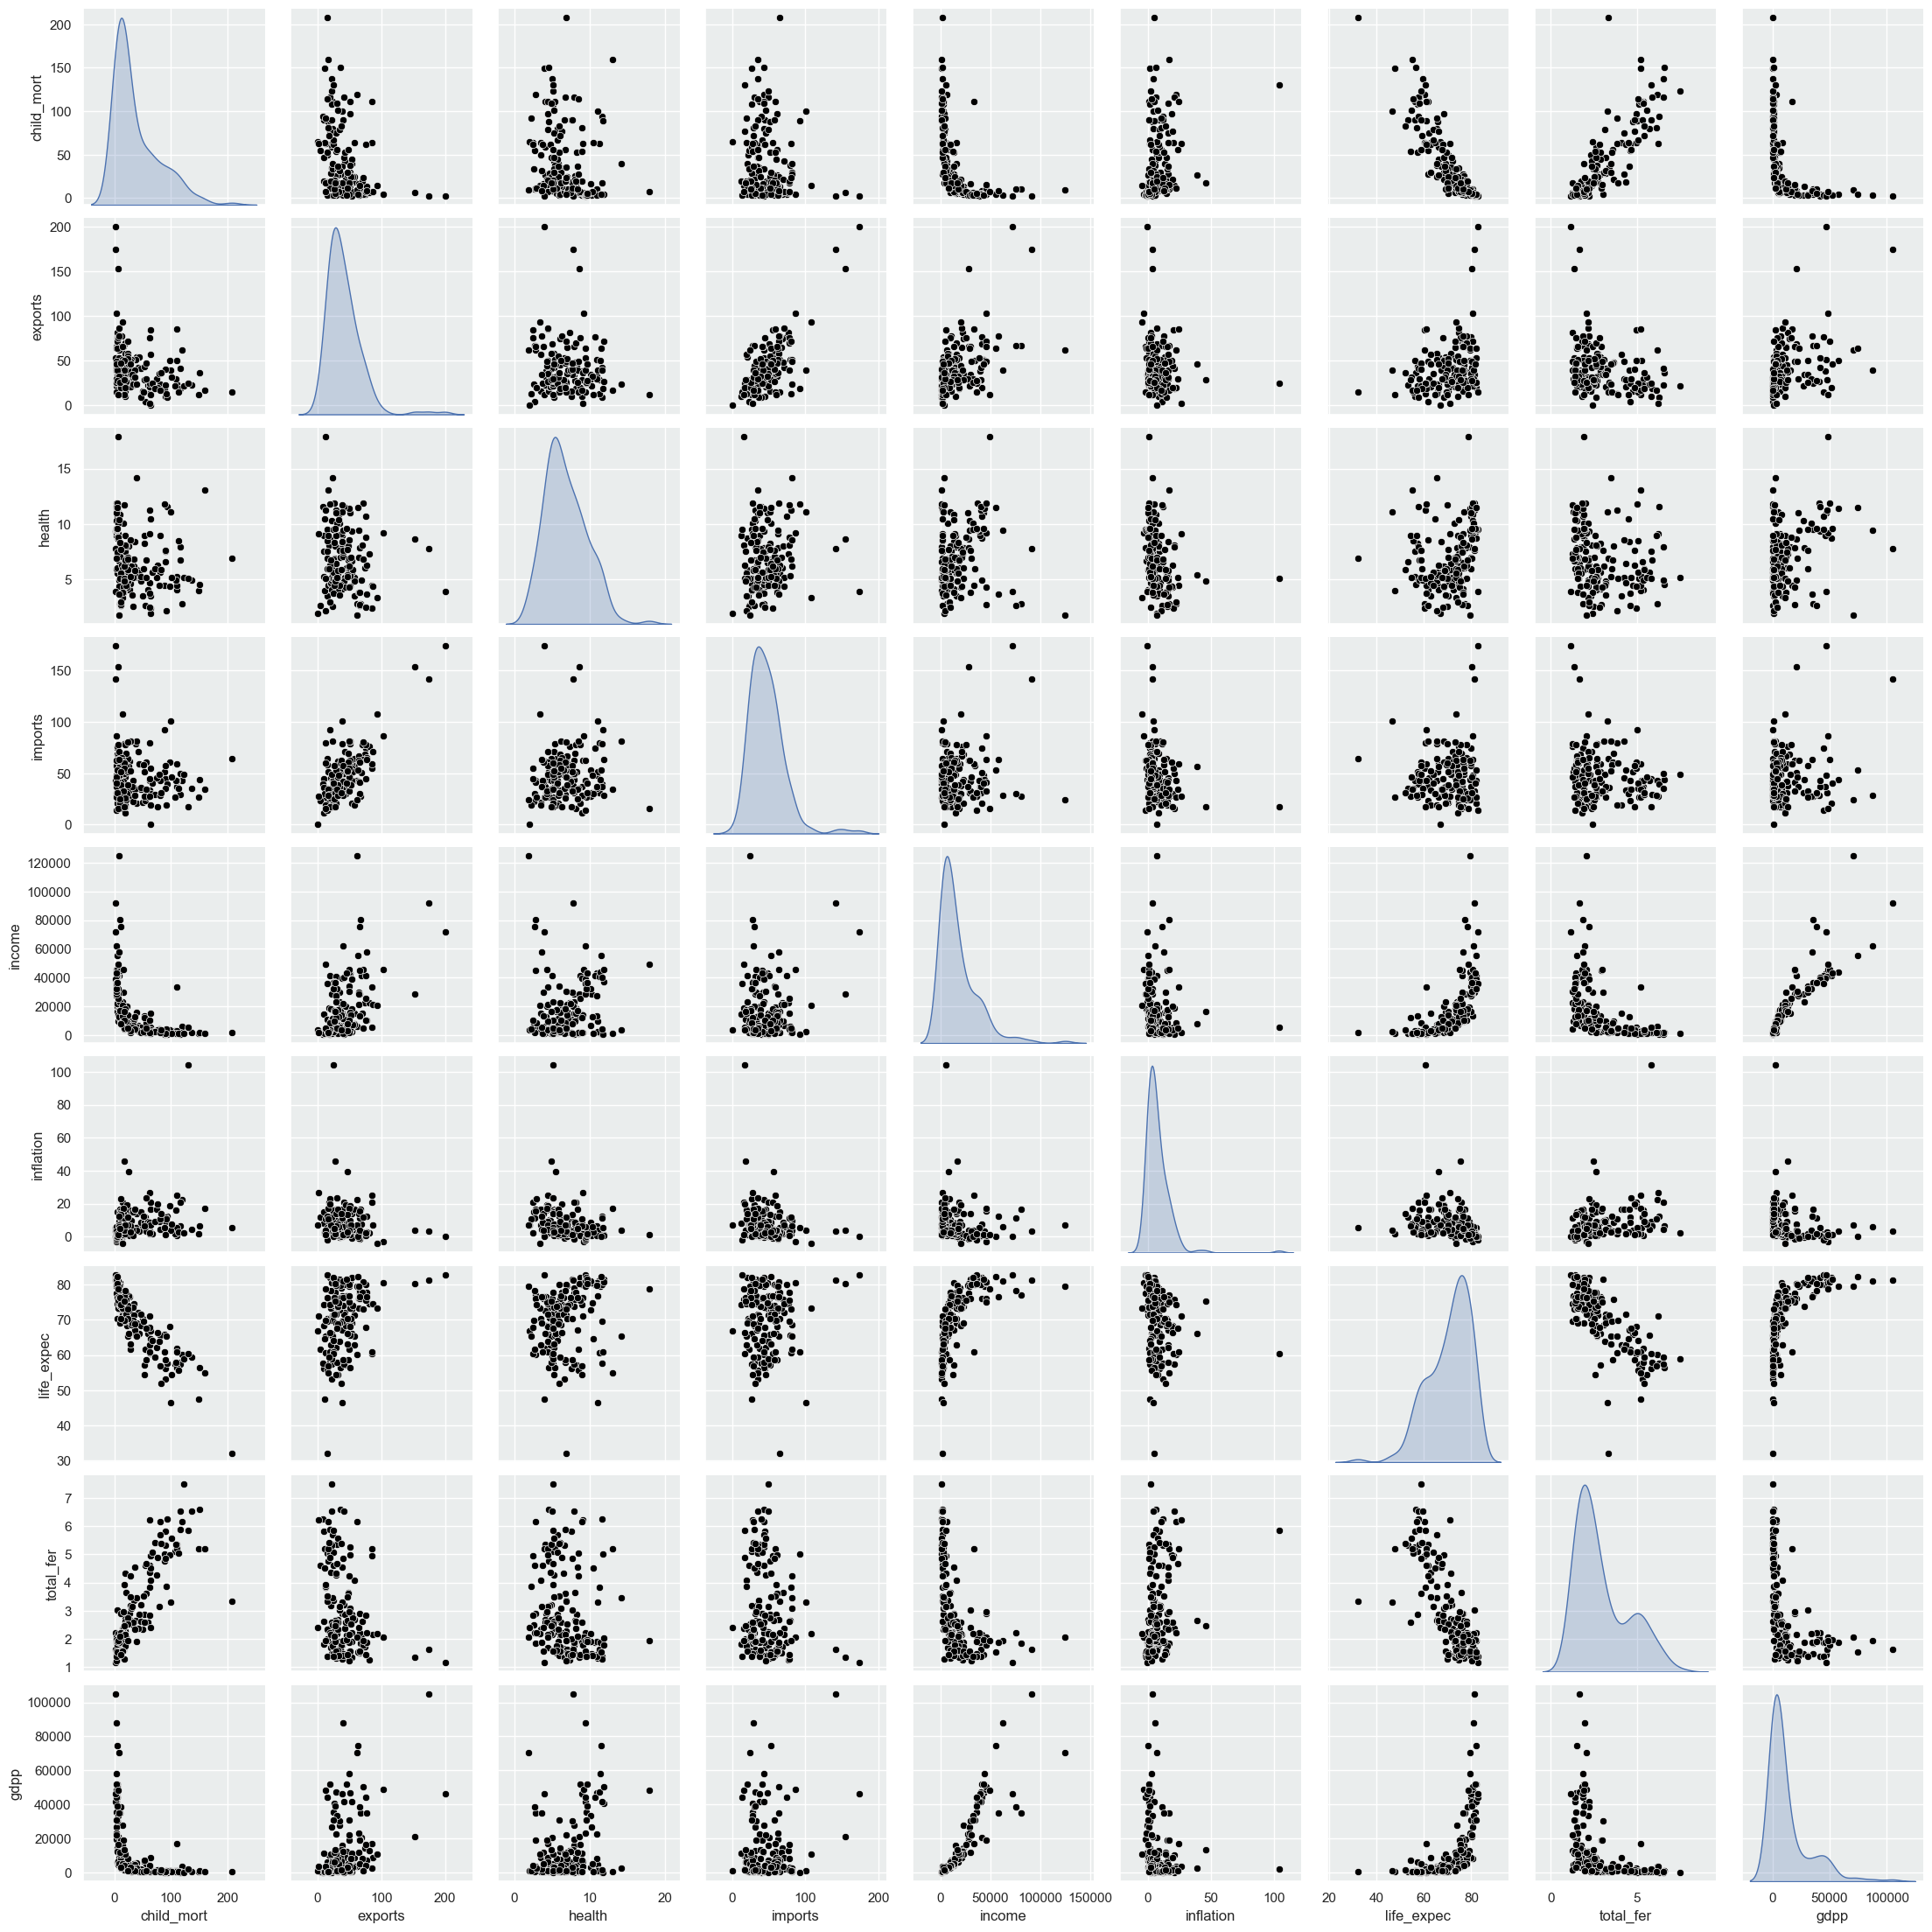

In [8]:
sns.set(style="darkgrid", rc={'axes.facecolor': '#EAEDED', 'grid.color': '#FFFFFF'})
sns.pairplot(country.drop('country', axis=1), diag_kind='kde', markers='o', plot_kws={'color': 'black'})
plt.show()


In [9]:
country_cor = country.drop('country',axis=1).corr()
country_cor

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
child_mort,1.000000,-0.318093,-0.200402,-0.127211,-0.524315,0.288276,-0.886676,0.848478,-0.483032
exports,-0.318093,1.000000,-0.114408,0.737381,0.516784,-0.107294,0.316313,-0.320011,0.418725
health,-0.200402,-0.114408,1.000000,0.095717,0.129579,-0.255376,0.210692,-0.196674,0.345966
imports,-0.127211,0.737381,0.095717,1.000000,0.122406,-0.246994,0.054391,-0.159048,0.115498
income,-0.524315,0.516784,0.129579,0.122406,1.000000,-0.147756,0.611962,-0.501840,0.895571
inflation,0.288276,-0.107294,-0.255376,-0.246994,-0.147756,1.000000,-0.239705,0.316921,-0.221631
life_expec,-0.886676,0.316313,0.210692,0.054391,0.611962,-0.239705,1.000000,-0.760875,0.600089
total_fer,0.848478,-0.320011,-0.196674,-0.159048,-0.501840,0.316921,-0.760875,1.000000,-0.454910
gdpp,-0.483032,0.418725,0.345966,0.115498,0.895571,-0.221631,0.600089,-0.454910,1.000000


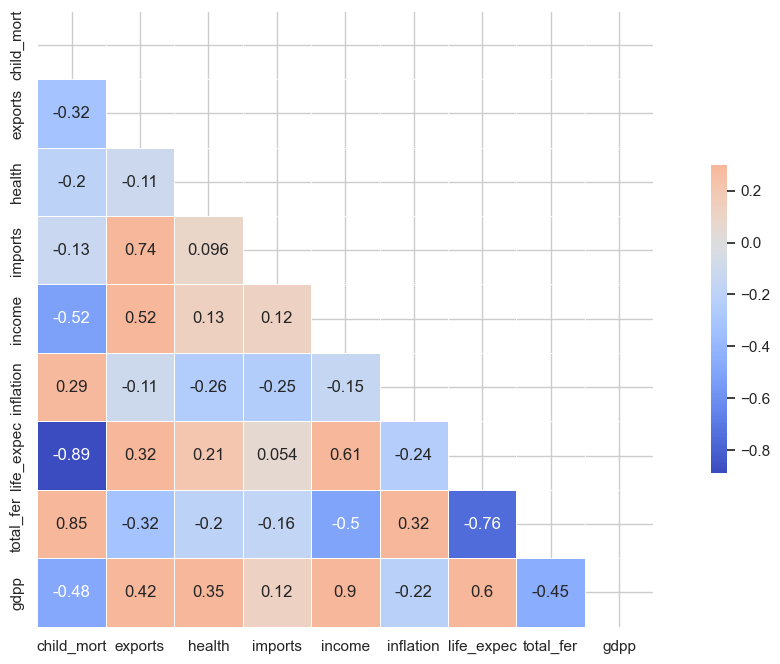

In [18]:
# Correlación de las variables
mask = np.triu(np.ones_like(country_cor, dtype=bool))
fig, ax = plt.subplots(figsize=(15, 8))
cmap = sns.color_palette("coolwarm", as_cmap=True)

sns.heatmap(country_cor, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()


In [19]:
# Estandarización de los datos
min_max_scaler = MinMaxScaler()
country_scale = min_max_scaler.fit_transform(country.drop('country',axis=1))
country_scale_df = pd.DataFrame(data = country_scale,
                               columns=country.columns[1:])
# Calcular la matriz de covarianza
cov_matrix = np.cov(country_scale_df, rowvar=False)
country_scale_df['country'] = country['country']
country_scale_df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,country
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073,Afghanistan
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833,Albania
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365,Algeria
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488,Angola
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242,Antigua and Barbuda


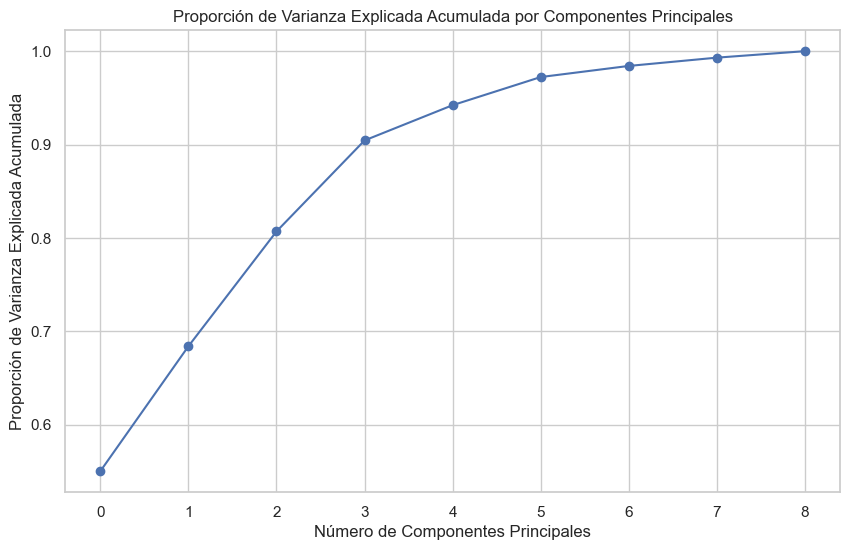

In [20]:
# Calcular eigenvectores y eigenvalores
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)

cumulative_explained_variance = np.cumsum(explained_variance_ratio)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance, marker='o', linestyle='-', color='b')
plt.title('Proporción de Varianza Explicada Acumulada por Componentes Principales')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Proporción de Varianza Explicada Acumulada')
plt.grid(True)
plt.show()

In [21]:
#Componentes principales
country_pca = PCA(n_components=5).fit(country_scale).transform(country_scale)

country_pca= pd.DataFrame(data = country_pca, columns = ['principal component 0', 'principal component 1',
                                                        'principal component 2','principal component 3',
                                                        'principal component 4'])
country_pca.head()

,principal component 0,principal component 1,principal component 2,principal component 3,principal component 4
0,-0.599078,0.095490,0.157554,-0.024333,-0.045618
1,0.158474,-0.212092,-0.064189,-0.061247,0.014191
2,0.003686,-0.135867,-0.134182,0.133574,-0.091150
3,-0.650235,0.275975,-0.142672,0.156018,-0.081997
4,0.200711,-0.064662,-0.100715,-0.037902,-0.035799


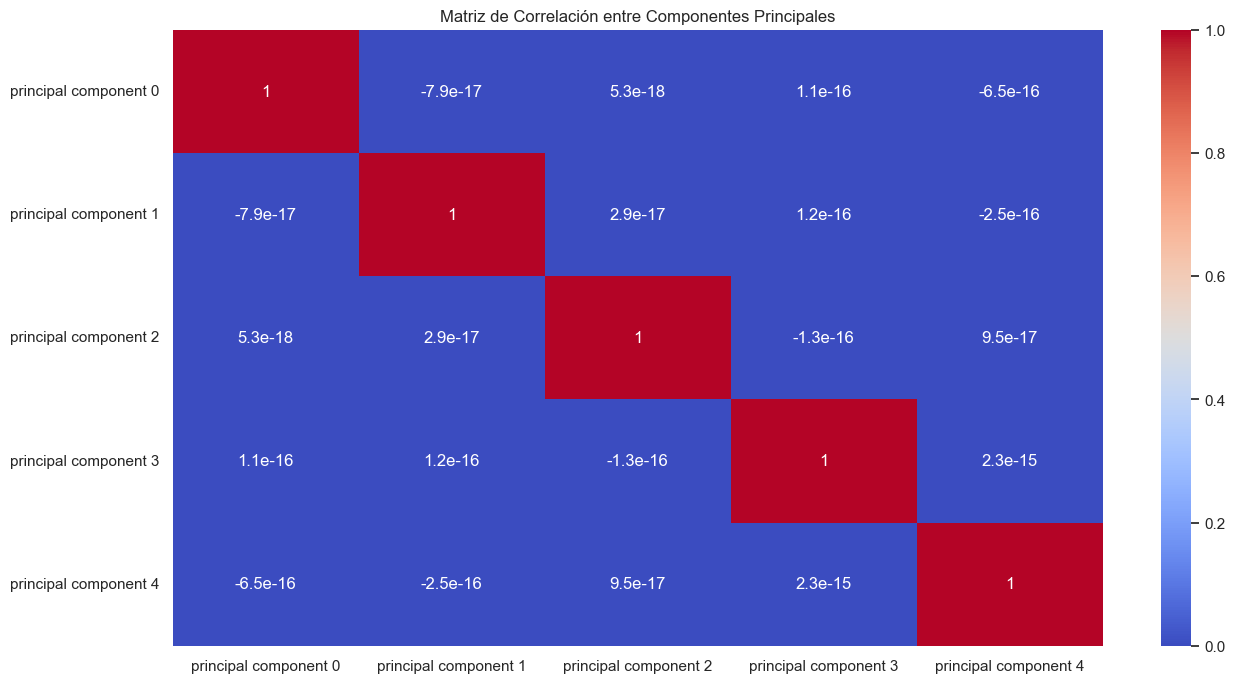

In [22]:
sns.heatmap(country_pca.corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación entre Componentes Principales')
plt.show()

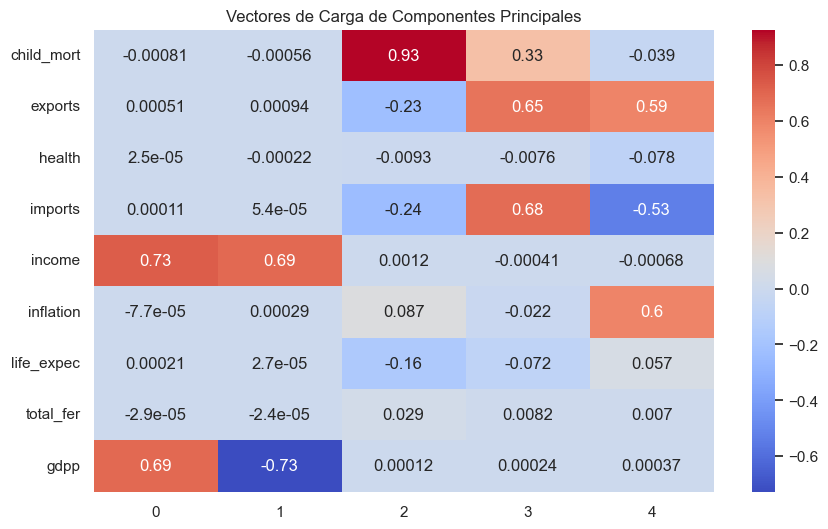

In [23]:
# Vectores de carga de los componentes principales
features = country.drop('country', axis=1)
pca = PCA(n_components=5)
country_pca = pca.fit_transform(features)
loadings = pd.DataFrame(pca.components_, columns=features.columns)
loadings = loadings.transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(loadings, annot=True, cmap='coolwarm')
plt.title('Vectores de Carga de Componentes Principales')
plt.show()


In [24]:
# Análisis

<Figure size 1200x600 with 0 Axes>

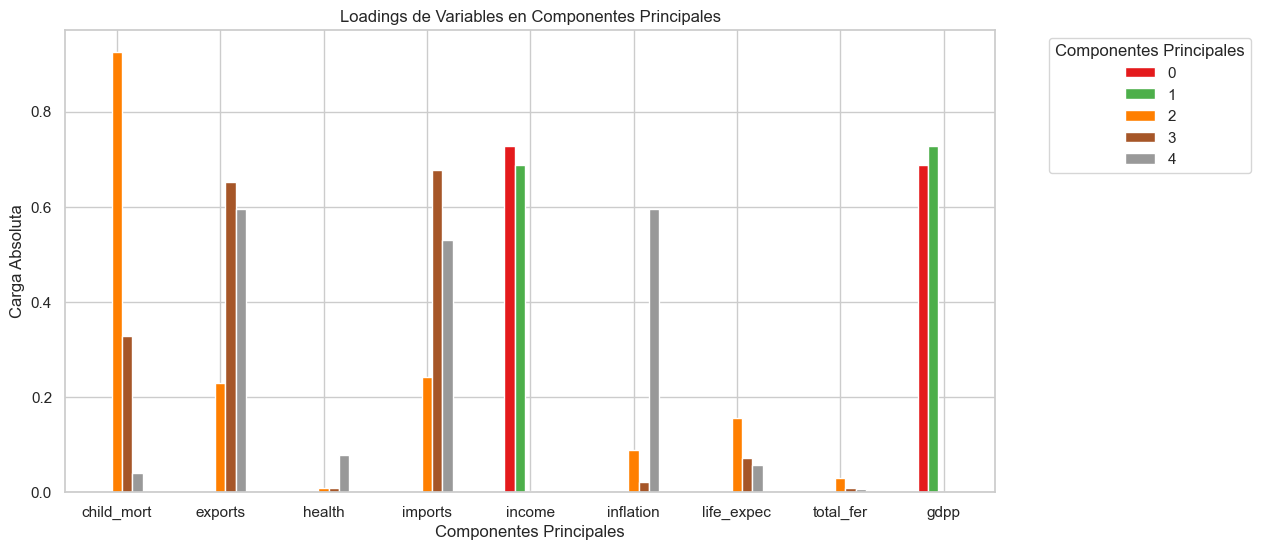

In [62]:
# Visualizar los loadings
plt.figure(figsize=(12, 6))
ax = loadings.abs().plot(kind='bar', figsize=(12, 6), colormap='Set1')

# Configuraciones adicionales para personalización
ax.legend(title='Componentes Principales', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title('Loadings de Variables en Componentes Principales')
ax.set_xlabel('Componentes Principales')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_ylabel('Carga Absoluta')
plt.show()


In [63]:
#Clasificacion en clusters

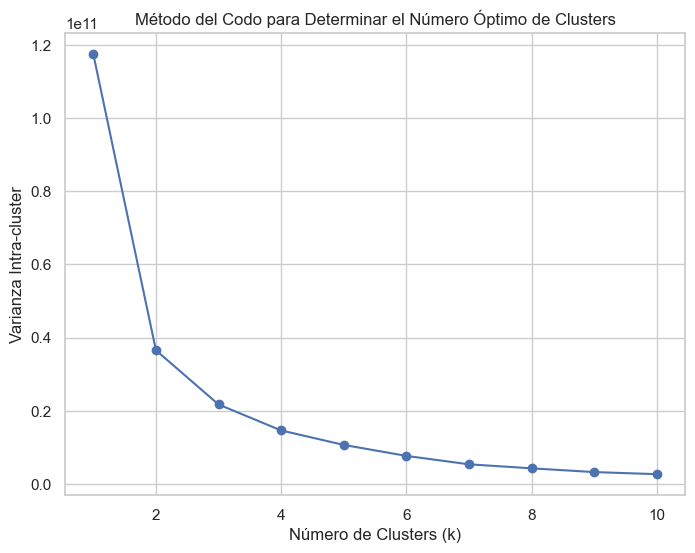

In [64]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(country_pca)
    inertia.append(kmeans.inertia_)

# Graficar la varianza intra-cluster en función de k
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Método del Codo para Determinar el Número Óptimo de Clusters')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Varianza Intra-cluster')
plt.show()


In [65]:
num_clusters = 4

# Inicializar el modelo de KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Aplicar KMeans a los datos después de PCA
clusters = kmeans.fit_predict(country_pca)

# Agregar la columna 'cluster' al DataFrame original 'country'
country['cluster'] = clusters

# Visualizar los resultados
print(country[['country', 'cluster']])


                 country  cluster
0            Afghanistan        0
1                Albania        0
2                Algeria        0
3                 Angola        0
4    Antigua and Barbuda        2
..                   ...      ...
162              Vanuatu        0
163            Venezuela        2
164              Vietnam        0
165                Yemen        0
166               Zambia        0

[167 rows x 2 columns]


In [66]:
country[country['cluster'] == 0][:10]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster,cluster_after_pca,cluster_before_pca
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.440,56.2,5.82,553,0,0,0
1,Albania,16.6,28.0,6.55,48.6,9930,4.490,76.3,1.65,4090,0,0,2
2,Algeria,27.3,38.4,4.17,31.4,12900,16.100,76.5,2.89,4460,0,0,2
3,Angola,119.0,62.3,2.85,42.9,5900,22.400,60.1,6.16,3530,0,0,0
6,Armenia,18.1,20.8,4.40,45.3,6700,7.770,73.3,1.69,3220,0,0,2
9,Azerbaijan,39.2,54.3,5.88,20.7,16000,13.800,69.1,1.92,5840,0,0,2
12,Bangladesh,49.4,16.0,3.52,21.8,2440,7.140,70.4,2.33,758,0,0,2
14,Belarus,5.5,51.4,5.61,64.5,16200,15.100,70.4,1.49,6030,0,0,2
16,Belize,18.8,58.2,5.20,57.5,7880,1.140,71.4,2.71,4340,0,0,2
17,Benin,111.0,23.8,4.10,37.2,1820,0.885,61.8,5.36,758,0,0,0


In [67]:
country[country['cluster'] == 1][:10]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster,cluster_after_pca,cluster_before_pca
7,Australia,4.8,19.8,8.73,20.9,41400,1.160,82.0,1.93,51900,1,1,1
8,Austria,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900,1,1,1
15,Belgium,4.5,76.4,10.70,74.7,41100,1.880,80.0,1.86,44400,1,1,1
23,Brunei,10.5,67.4,2.84,28.0,80600,16.700,77.1,1.84,35300,1,1,1
29,Canada,5.6,29.1,11.30,31.0,40700,2.870,81.3,1.63,47400,1,1,1
44,Denmark,4.1,50.5,11.40,43.6,44000,3.220,79.5,1.87,58000,1,1,1
53,Finland,3.0,38.7,8.95,37.4,39800,0.351,80.0,1.87,46200,1,1,1
54,France,4.2,26.8,11.90,28.1,36900,1.050,81.4,2.03,40600,1,1,1
58,Germany,4.2,42.3,11.60,37.1,40400,0.758,80.1,1.39,41800,1,1,1
68,Iceland,2.6,53.4,9.40,43.3,38800,5.470,82.0,2.20,41900,1,1,1


In [68]:
country[country['cluster'] == 2][:10]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster,cluster_after_pca,cluster_before_pca
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.440,76.8,2.13,12200,2,2,2
5,Argentina,14.5,18.9,8.10,16.0,18700,20.900,75.8,2.37,10300,2,2,2
10,Bahamas,13.8,35.0,7.89,43.7,22900,-0.393,73.8,1.86,28000,2,2,2
11,Bahrain,8.6,69.5,4.97,50.9,41100,7.440,76.0,2.16,20700,2,2,2
13,Barbados,14.2,39.5,7.97,48.7,15300,0.321,76.7,1.78,16000,2,2,2
33,Chile,8.7,37.7,7.96,31.3,19400,8.960,79.1,1.88,12900,2,2,2
41,Croatia,5.5,37.6,7.76,38.1,20100,0.821,76.3,1.55,13500,2,2,2
42,Cyprus,3.6,50.2,5.97,57.5,33900,2.010,79.9,1.42,30800,2,2,1
43,Czech Republic,3.4,66.0,7.88,62.9,28300,-1.430,77.5,1.51,19800,2,2,1
49,Equatorial Guinea,111.0,85.8,4.48,58.9,33700,24.900,60.9,5.21,17100,2,2,0


In [69]:
country[country['cluster'] == 3][:10]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster,cluster_after_pca,cluster_before_pca
91,Luxembourg,2.8,175.0,7.77,142.0,91700,3.62,81.3,1.63,105000,3,3,3
114,Norway,3.2,39.7,9.48,28.5,62300,5.95,81.0,1.95,87800,3,3,1
123,Qatar,9.0,62.3,1.81,23.8,125000,6.98,79.5,2.07,70300,3,3,1


               country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  cluster  cluster_after_pca  \
0       9.44        56.2       5.82    553        0                  0   
1       4.49        76.3       1.65   4090        0                  0   
2      16.10        76.5       2.89   4460        0                  0   
3      22.40        60.1       6.16   3530        0                  0   
4       1.44        76.8       2.13  12200        2                  2   

   cluster_before_pca  
0                   0  
1                   2  
2                   2  
3                   0  
4 

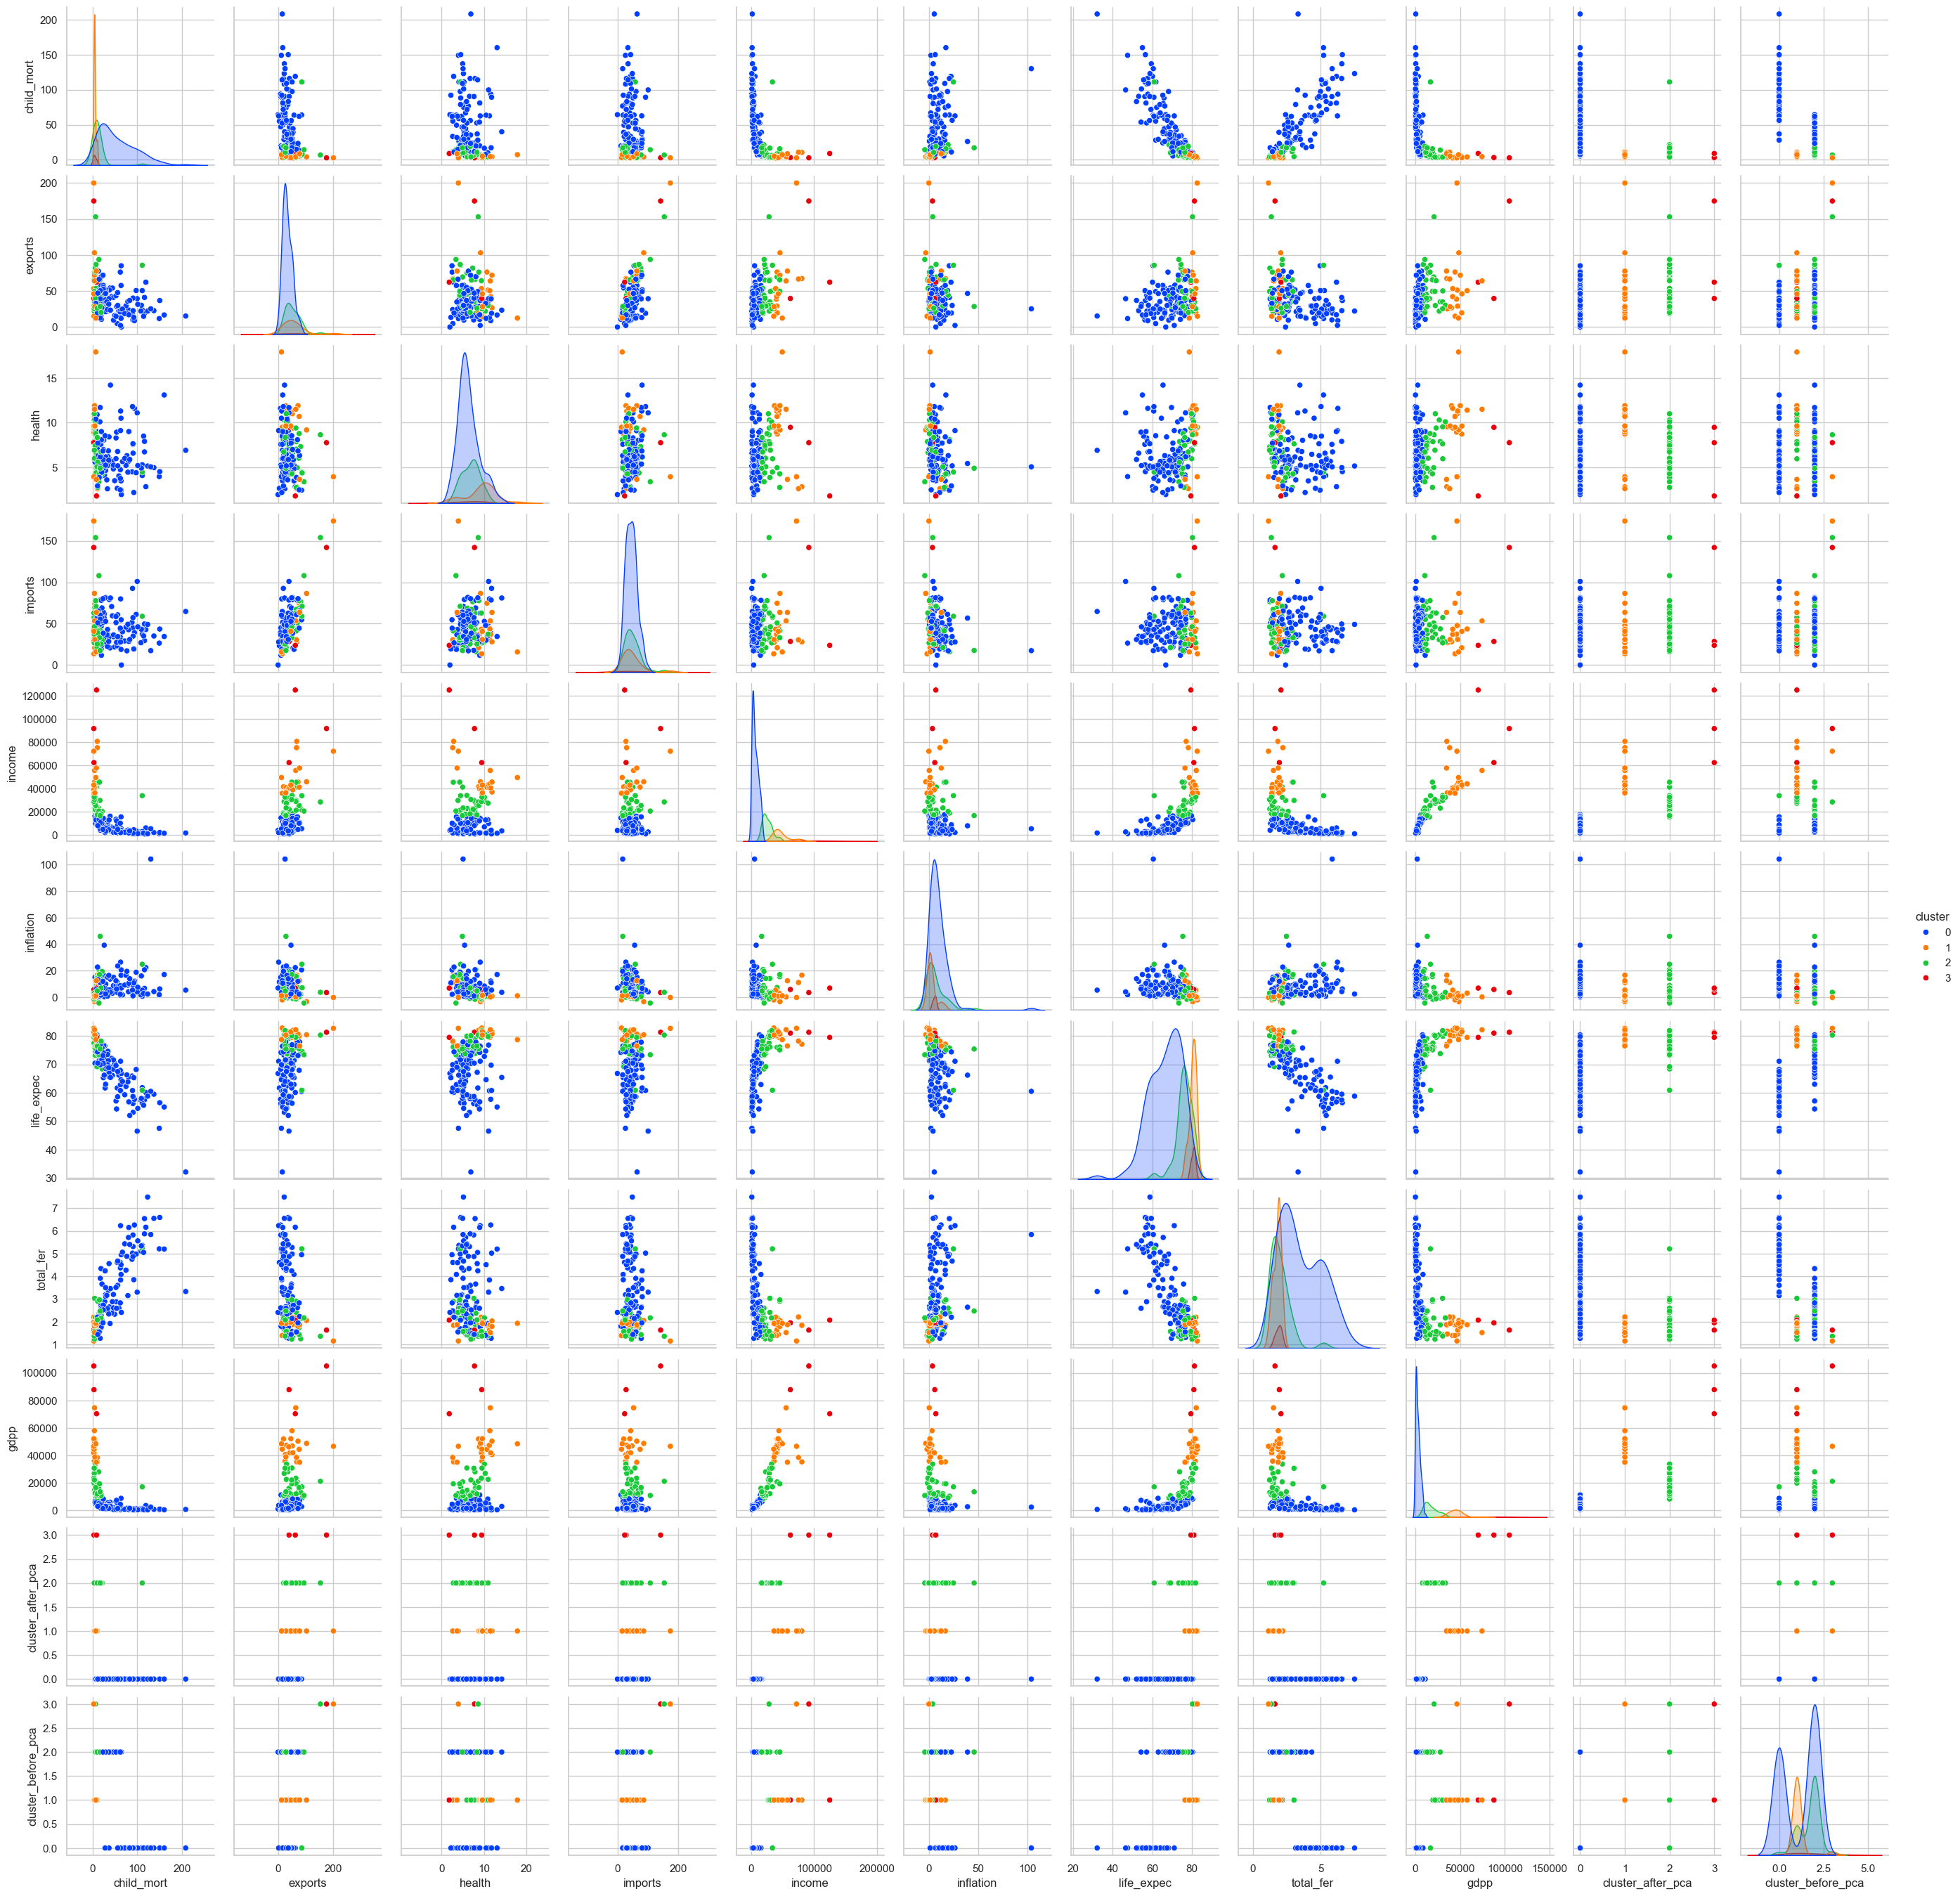

In [70]:
print(country.head())
sns.pairplot(country.drop('country', axis=1), hue='cluster', palette='bright')
plt.show()

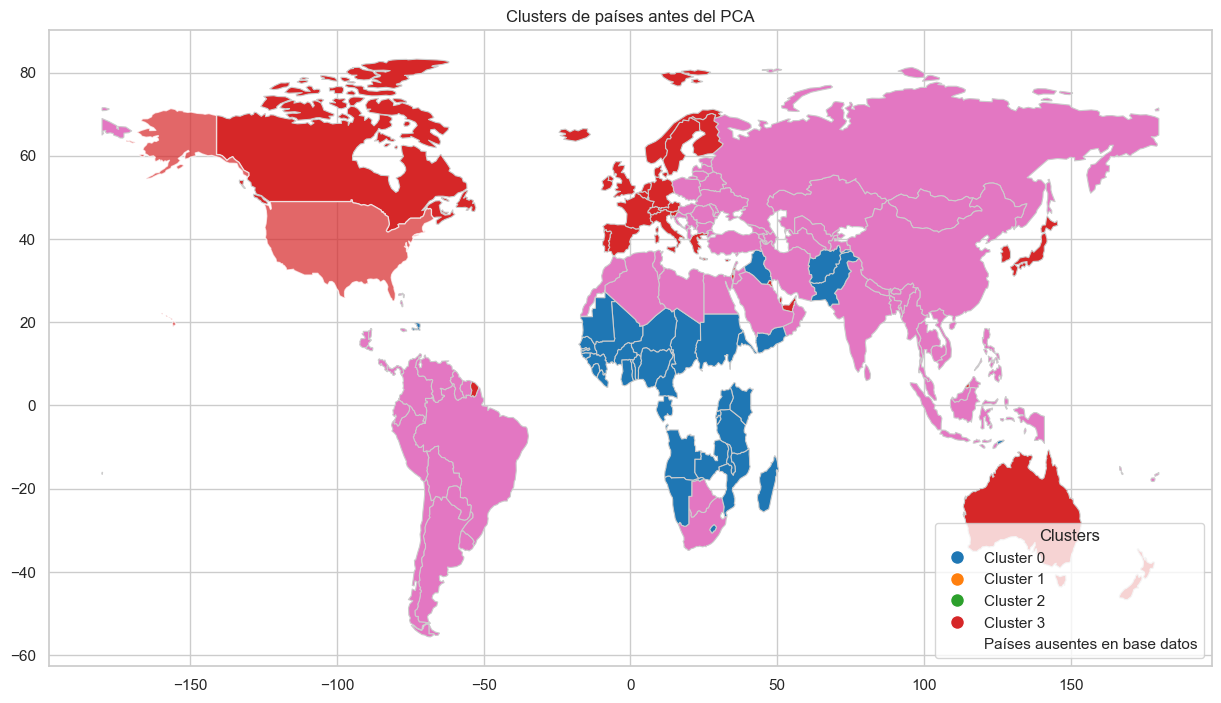

In [77]:
import geopandas as gpd
from matplotlib.lines import Line2D

# Supongamos que 'country' ya contiene la columna 'cluster_before_pca'

# Creación del mapa
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Trazar los países con colores según los clusters antes del PCA
world.plot(column='cluster_before_pca', cmap='tab10', linewidth=0.8, ax=ax, edgecolor='0.8', legend=False)

# Añadir un punto representativo del Cluster 3 (por ejemplo, USA)
cluster_3_color = plt.cm.tab10(3)
world[world['iso_a3'] == 'USA'].plot(ax=ax, color=cluster_3_color, marker='o', markersize=100, alpha=0.7, label='Cluster 3 (por ejemplo, USA)')

plt.title('Clusters de países antes del PCA')

# Leyenda
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab10(i), markersize=10, label=f'Cluster {i}') for i in range(4)]
legend_elements.append(Line2D([0], [0], marker='', color='w', markerfacecolor='w', markersize=0, label='Países ausentes en base datos'))
ax.legend(handles=legend_elements, title='Clusters', loc='lower right')

plt.show()


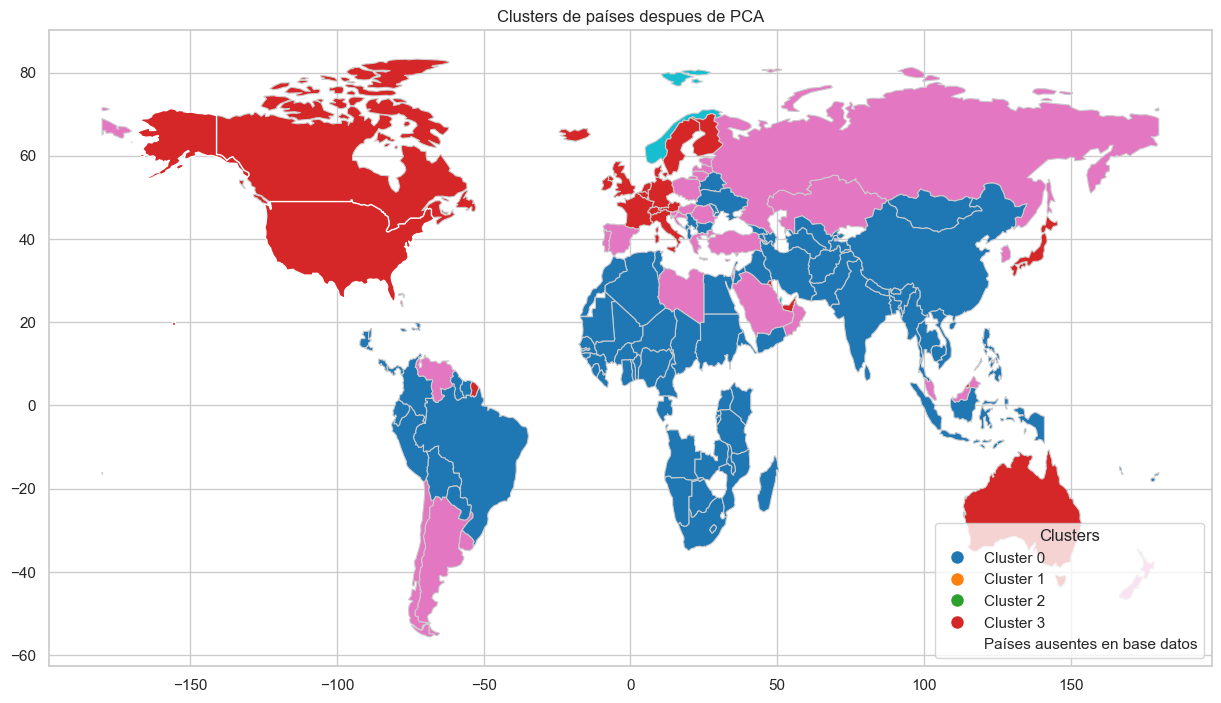

In [78]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(country, how='left', left_on='name', right_on='country')

# Creación mapa
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Trazar los países con colores según los clusters
world.plot(column='cluster', cmap='tab10', linewidth=0.8, ax=ax, edgecolor='0.8', legend=False)

cluster_3_color = plt.cm.tab10(3)
world[world['iso_a3'] == 'USA'].plot(ax=ax, color=cluster_3_color)

plt.title('Clusters de países despues de PCA')

#leyenda
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab10(i), markersize=10, label=f'Cluster {i}') for i in range(4)]
legend_elements.append(Line2D([0], [0], marker='', color='w', markerfacecolor='w', markersize=0, label='Países ausentes en base datos'))
ax.legend(handles=legend_elements, title='Clusters', loc='lower right')

plt.show()

In [79]:
y = country['exports']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(country_pca, y, test_size=0.2, random_state=42)

# Regresión lineal con componentes principales
reg_with_pca = LinearRegression()
reg_with_pca.fit(X_train, y_train)
y_pred_with_pca = reg_with_pca.predict(X_test)
mse_with_pca = mean_squared_error(y_test, y_pred_with_pca)

print(f'Regresión Lineal con Componentes Principales:')
print(f'Coeficientes: {reg_with_pca.coef_}')
print(f'Intercept: {reg_with_pca.intercept_}')
print(f'MSE con PCA: {mse_with_pca}')


Regresión Lineal con Componentes Principales:
Coeficientes: [ 5.12441266e-04  9.26851390e-04 -2.34237307e-01  6.56294068e-01
  5.61131320e-01]
Intercept: 41.03053312147899
MSE con PCA: 9.540334481180945


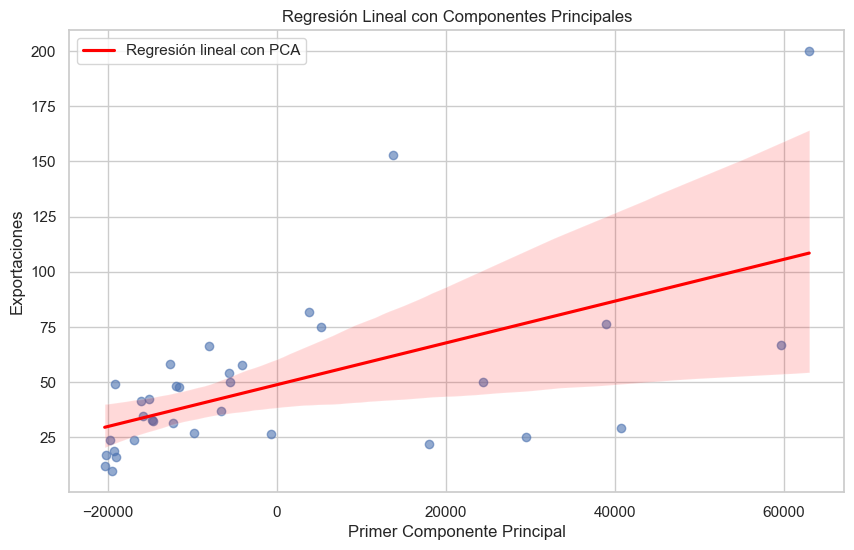

In [80]:
# Graficar la regresión lineal con componentes principales
plt.figure(figsize=(10, 6))
sns.regplot(x=X_test[:, 0], y=y_test, scatter_kws={'alpha':0.6}, line_kws={'color': 'red', 'label': 'Regresión lineal con PCA'})
plt.title('Regresión Lineal con Componentes Principales')
plt.xlabel('Primer Componente Principal')
plt.ylabel('Exportaciones')
plt.legend()
plt.show()

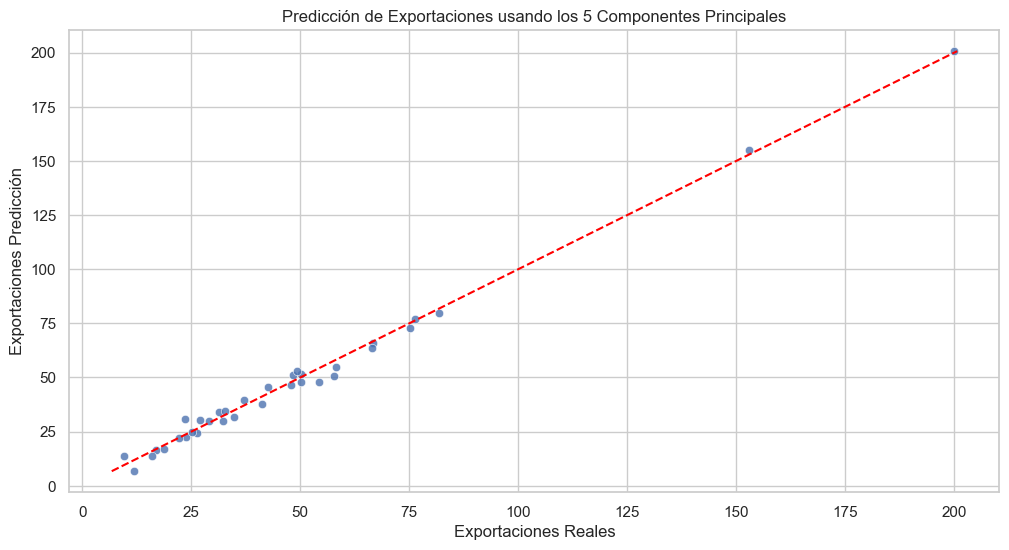

In [81]:
# Hacer predicciones en el conjunto de prueba
predictions_all_components = reg_with_pca.predict(X_test)

# Crear un DataFrame para la visualización de la predicción
df_prediccion_all_components = pd.DataFrame({
    'Exportaciones Real': y_test,
    'Exportaciones Predicción': predictions_all_components
})

# Graficar las exportaciones reales y la predicción para cada país en el conjunto de prueba
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Exportaciones Real', y='Exportaciones Predicción', data=df_prediccion_all_components, alpha=0.8)
plt.plot([df_prediccion_all_components.min().min(), df_prediccion_all_components.max().max()], [df_prediccion_all_components.min().min(), df_prediccion_all_components.max().max()], linestyle='--', color='red')
plt.title('Predicción de Exportaciones usando los 5 Componentes Principales')
plt.xlabel('Exportaciones Reales')
plt.ylabel('Exportaciones Predicción')
plt.show()



